problems: 2 and 3

##### Question 2


| Task \ Augmentation  | A. Horizontal Flip | B. Random Rotation | C. Color Jitter | D. Gaussian Noise | E. Random Crop & Resize |
|----------------------|--------------------|--------------------|----------------|------------------|----------------------|
| **1. Determining Image Orientation** | × | ✓ | × | × | × |
| **2. Arrow Direction Detection** | × | ✓ | × | × | × |
| **3. Image Cleanliness Classification** | × | × | × | ✓ | × |
| **4. Object Size Detection** | × | × | × | × | ✓ |
| **5. Handwritten Digit Recognition** | × | ✓ | × | × | ✓ |
| **6. Facial Recognition** | ✓ | ✓ | ✓ | × | ✓ |
| **7. Medical Tumor Detection** | × | × | × | × | × |
| **8. OCR for Printed Text** | × | × | × | × | × |
| **9. Animal Species Classification** | ✓ | ✓ | ✓ | × | ✓ |
| **10. Barcode Scanning** | × | ✓ | × | × | ✓ |

##### Question 3

A) Done  
B) The model did not converge after ten epochs  
C) The filters look like some of the images main colors  
D) It is WAYYYYY faster to train on GPU

In [20]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [21]:
from torchvision import datasets
from torchvision import transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])
db_train = datasets.CIFAR10(root='./', train=True, transform=transform, download=True)
db_test = datasets.CIFAR10(root='./', train=False, transform=transform, download=True)
def subsample(db, n):
    idx = np.random.permutation(len(db))[:n]
    db.data = db.data[idx]
    db.targets = np.array(db.targets)[idx]
    return db

db_train = subsample(db_train, 5000)
db_test = subsample(db_test, 1000)

img, y = db_train[0]
print(img.shape, img.min(), img.max(), y)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32]) tensor(0.0078) tensor(0.8157) 6


### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.
Note that transforms.ToTensor transformed our image 32x32x3 image into a 3x32x32 tensor (the format that Conv2d layers expect). 
However, to display the image, we need to permute its dimensions again.


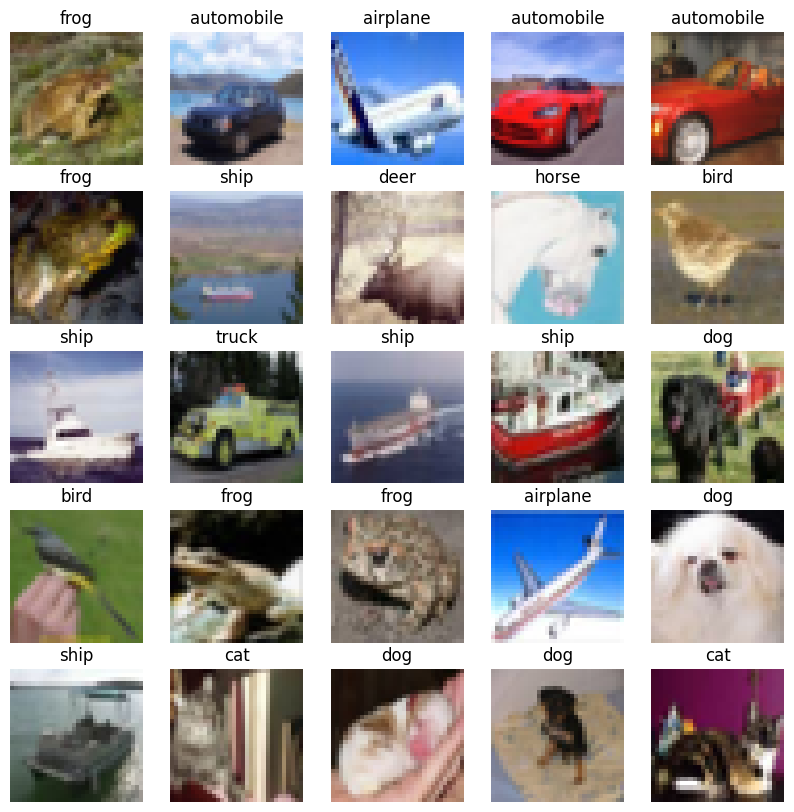

In [22]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    img, lbl = db_train[i]
    plt.subplot(5,5,i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_names[lbl])
    plt.axis(False)
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and [MaxPooling2D](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [23]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=(5, 5)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Conv2d(32, 64, kernel_size=(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Conv2d(64, 64, kernel_size=(3, 3)),
    nn.ReLU(),
)
dummy_img = torch.randn(1, 3, 32, 32)
print(model(dummy_img).shape)

torch.Size([1, 64, 4, 4])


The output of every Conv2d and MaxPool2d layer is a 3D tensor of shape (channels, height, width). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2d layer is controlled by the second argument (e.g., 32 or 64). Typically, as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2d layer. By feeding a dummy image, we observe that the model so far will output a (64, 4, 4) tensor.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base of shape (64, 4, 4) into one or more Linear layers to perform classification. Linear layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten the 3D output to 1D, then add one or more Linear layers on top. CIFAR has 10 output classes, so you use a final Linear layer with 10 outputs. Since the convolutional base outputs 64x4x4 tensors, after flattening, we will have 1024 input features to the Linear layer.

In [24]:
model.add_module("flatten", nn.Flatten())
model.add_module("classifier", nn.Linear(1024, 10))

Here's the complete architecture of your model:

In [25]:
print(model)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Linear(in_features=1024, out_features=10, bias=True)
)


### Compile and train the model

In [26]:
from torch.utils.data import DataLoader
import tqdm

def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.normal_(m.weight, mean=0, std=0.001)

def fit_one_epoch(model, opt, loader):
    losses, accuracies = [], []
    for images, labels in tqdm.tqdm(loader):
        pred = model(images)
        l = loss(pred, labels)
        acc = (pred.argmax(1) == labels).float().mean()
    
        l.backward()
        opt.step()
        opt.zero_grad()
        
        losses.append(l.detach().item())
        accuracies.append(acc.detach().item())
    return np.mean(losses), np.mean(accuracies)

@torch.no_grad()
def eval(model, loader):
    accuracies = []
    for images, labels in tqdm.tqdm(loader):
        pred = model(images)
        acc = (pred.argmax(1) == labels).float().mean()
        accuracies.append(acc.detach().item())
    return np.mean(accuracies)


def fit(model, loader_train, loader_test, epochs=50):
    opt = torch.optim.Adam(model.parameters(), lr=0.0005)
    hist_tr_loss, hist_tr_acc, hist_te_acc = [], [], []
    for epoch in range(epochs):
        tr_l, tr_acc = fit_one_epoch(model, opt, loader_train)
        te_acc = eval(model, loader_test)
        
        print(f"Finished epoch {epoch} of {epochs}: Train Loss = {tr_l:.3f}   Train Acc = {tr_acc:.3f}   Test Acc = {te_acc:.3f}", flush=True)
        hist_tr_loss.append(tr_l)
        hist_tr_acc.append(tr_acc)
        hist_te_acc.append(te_acc)
    return hist_tr_loss, hist_tr_acc, hist_te_acc

loader_train = DataLoader(db_train, batch_size=64, shuffle=True, drop_last=True)
loader_test = DataLoader(db_test, batch_size=64, shuffle=False)
loss = nn.CrossEntropyLoss()
init_weights(model)
hist_tr_loss, hist_tr_acc, hist_te_acc = fit(model, loader_train, loader_test)

100%|██████████| 16/16 [00:00<00:00, 63.17it/s]

Finished epoch 0 of 50: Train Loss = 2.293   Train Acc = 0.109   Test Acc = 0.101



100%|██████████| 16/16 [00:00<00:00, 59.72it/s]

Finished epoch 1 of 50: Train Loss = 2.224   Train Acc = 0.135   Test Acc = 0.172



100%|██████████| 16/16 [00:00<00:00, 62.44it/s]

Finished epoch 2 of 50: Train Loss = 2.172   Train Acc = 0.199   Test Acc = 0.234



100%|██████████| 16/16 [00:00<00:00, 63.71it/s]

Finished epoch 3 of 50: Train Loss = 2.050   Train Acc = 0.224   Test Acc = 0.237



100%|██████████| 16/16 [00:00<00:00, 58.16it/s]

Finished epoch 4 of 50: Train Loss = 2.009   Train Acc = 0.242   Test Acc = 0.247



100%|██████████| 16/16 [00:00<00:00, 62.37it/s]

Finished epoch 5 of 50: Train Loss = 1.962   Train Acc = 0.254   Test Acc = 0.272



100%|██████████| 16/16 [00:00<00:00, 61.30it/s]

Finished epoch 6 of 50: Train Loss = 1.900   Train Acc = 0.275   Test Acc = 0.287



100%|██████████| 16/16 [00:00<00:00, 62.28it/s]

Finished epoch 7 of 50: Train Loss = 1.857   Train Acc = 0.293   Test Acc = 0.317



100%|██████████| 16/16 [00:00<00:00, 62.28it/s]

Finished epoch 8 of 50: Train Loss = 1.819   Train Acc = 0.309   Test Acc = 0.315



100%|██████████| 16/16 [00:00<00:00, 63.05it/s]

Finished epoch 9 of 50: Train Loss = 1.778   Train Acc = 0.330   Test Acc = 0.349



100%|██████████| 16/16 [00:00<00:00, 63.01it/s]

Finished epoch 10 of 50: Train Loss = 1.745   Train Acc = 0.345   Test Acc = 0.364



100%|██████████| 16/16 [00:00<00:00, 60.82it/s]

Finished epoch 11 of 50: Train Loss = 1.710   Train Acc = 0.361   Test Acc = 0.371



100%|██████████| 16/16 [00:00<00:00, 53.65it/s]

Finished epoch 12 of 50: Train Loss = 1.684   Train Acc = 0.378   Test Acc = 0.396



100%|██████████| 16/16 [00:00<00:00, 62.56it/s]

Finished epoch 13 of 50: Train Loss = 1.656   Train Acc = 0.380   Test Acc = 0.392



100%|██████████| 16/16 [00:00<00:00, 63.11it/s]

Finished epoch 14 of 50: Train Loss = 1.641   Train Acc = 0.396   Test Acc = 0.388



100%|██████████| 16/16 [00:00<00:00, 62.16it/s]

Finished epoch 15 of 50: Train Loss = 1.619   Train Acc = 0.396   Test Acc = 0.385



100%|██████████| 16/16 [00:00<00:00, 62.73it/s]

Finished epoch 16 of 50: Train Loss = 1.612   Train Acc = 0.401   Test Acc = 0.407



100%|██████████| 16/16 [00:00<00:00, 63.64it/s]

Finished epoch 17 of 50: Train Loss = 1.598   Train Acc = 0.415   Test Acc = 0.368



100%|██████████| 16/16 [00:00<00:00, 63.06it/s]

Finished epoch 18 of 50: Train Loss = 1.580   Train Acc = 0.421   Test Acc = 0.399



100%|██████████| 16/16 [00:00<00:00, 63.96it/s]

Finished epoch 19 of 50: Train Loss = 1.580   Train Acc = 0.417   Test Acc = 0.417



100%|██████████| 16/16 [00:00<00:00, 62.02it/s]

Finished epoch 20 of 50: Train Loss = 1.560   Train Acc = 0.421   Test Acc = 0.420



100%|██████████| 16/16 [00:00<00:00, 52.94it/s]

Finished epoch 21 of 50: Train Loss = 1.533   Train Acc = 0.438   Test Acc = 0.423



100%|██████████| 16/16 [00:00<00:00, 62.75it/s]

Finished epoch 22 of 50: Train Loss = 1.513   Train Acc = 0.447   Test Acc = 0.427



100%|██████████| 16/16 [00:00<00:00, 61.47it/s]

Finished epoch 23 of 50: Train Loss = 1.496   Train Acc = 0.452   Test Acc = 0.433



100%|██████████| 16/16 [00:00<00:00, 61.96it/s]

Finished epoch 24 of 50: Train Loss = 1.494   Train Acc = 0.454   Test Acc = 0.433



100%|██████████| 16/16 [00:00<00:00, 61.62it/s]

Finished epoch 25 of 50: Train Loss = 1.470   Train Acc = 0.461   Test Acc = 0.419



100%|██████████| 16/16 [00:00<00:00, 54.82it/s]

Finished epoch 26 of 50: Train Loss = 1.451   Train Acc = 0.473   Test Acc = 0.436



100%|██████████| 16/16 [00:00<00:00, 61.61it/s]

Finished epoch 27 of 50: Train Loss = 1.433   Train Acc = 0.475   Test Acc = 0.443



100%|██████████| 16/16 [00:00<00:00, 58.62it/s]

Finished epoch 28 of 50: Train Loss = 1.419   Train Acc = 0.489   Test Acc = 0.446



100%|██████████| 16/16 [00:00<00:00, 55.37it/s]

Finished epoch 29 of 50: Train Loss = 1.416   Train Acc = 0.486   Test Acc = 0.446



100%|██████████| 16/16 [00:00<00:00, 61.08it/s]

Finished epoch 30 of 50: Train Loss = 1.413   Train Acc = 0.492   Test Acc = 0.467



100%|██████████| 16/16 [00:00<00:00, 57.89it/s]

Finished epoch 31 of 50: Train Loss = 1.394   Train Acc = 0.494   Test Acc = 0.458



100%|██████████| 16/16 [00:00<00:00, 57.32it/s]

Finished epoch 32 of 50: Train Loss = 1.396   Train Acc = 0.502   Test Acc = 0.450



100%|██████████| 16/16 [00:00<00:00, 54.95it/s]

Finished epoch 33 of 50: Train Loss = 1.367   Train Acc = 0.504   Test Acc = 0.465



100%|██████████| 16/16 [00:00<00:00, 51.17it/s]

Finished epoch 34 of 50: Train Loss = 1.354   Train Acc = 0.509   Test Acc = 0.451



100%|██████████| 16/16 [00:00<00:00, 47.46it/s]

Finished epoch 35 of 50: Train Loss = 1.343   Train Acc = 0.516   Test Acc = 0.456



100%|██████████| 16/16 [00:00<00:00, 59.20it/s]

Finished epoch 36 of 50: Train Loss = 1.336   Train Acc = 0.519   Test Acc = 0.454



100%|██████████| 16/16 [00:00<00:00, 62.19it/s]

Finished epoch 37 of 50: Train Loss = 1.344   Train Acc = 0.514   Test Acc = 0.463



100%|██████████| 16/16 [00:00<00:00, 54.76it/s]

Finished epoch 38 of 50: Train Loss = 1.325   Train Acc = 0.521   Test Acc = 0.470



100%|██████████| 16/16 [00:00<00:00, 65.93it/s]

Finished epoch 39 of 50: Train Loss = 1.314   Train Acc = 0.529   Test Acc = 0.479



100%|██████████| 16/16 [00:00<00:00, 57.81it/s]

Finished epoch 40 of 50: Train Loss = 1.304   Train Acc = 0.526   Test Acc = 0.471



100%|██████████| 16/16 [00:00<00:00, 60.06it/s]

Finished epoch 41 of 50: Train Loss = 1.303   Train Acc = 0.527   Test Acc = 0.483



100%|██████████| 16/16 [00:00<00:00, 59.77it/s]

Finished epoch 42 of 50: Train Loss = 1.279   Train Acc = 0.541   Test Acc = 0.479



100%|██████████| 16/16 [00:00<00:00, 59.78it/s]

Finished epoch 43 of 50: Train Loss = 1.273   Train Acc = 0.537   Test Acc = 0.479



100%|██████████| 16/16 [00:00<00:00, 56.93it/s]

Finished epoch 44 of 50: Train Loss = 1.274   Train Acc = 0.543   Test Acc = 0.474



100%|██████████| 16/16 [00:00<00:00, 54.08it/s]

Finished epoch 45 of 50: Train Loss = 1.259   Train Acc = 0.548   Test Acc = 0.488



100%|██████████| 16/16 [00:00<00:00, 58.26it/s]

Finished epoch 46 of 50: Train Loss = 1.244   Train Acc = 0.553   Test Acc = 0.497



100%|██████████| 16/16 [00:00<00:00, 59.21it/s]

Finished epoch 47 of 50: Train Loss = 1.248   Train Acc = 0.553   Test Acc = 0.478



100%|██████████| 16/16 [00:00<00:00, 65.82it/s]

Finished epoch 48 of 50: Train Loss = 1.234   Train Acc = 0.560   Test Acc = 0.493



100%|██████████| 16/16 [00:00<00:00, 66.46it/s]

Finished epoch 49 of 50: Train Loss = 1.226   Train Acc = 0.556   Test Acc = 0.498


### Evaluate the model

100%|██████████| 16/16 [00:00<00:00, 61.76it/s]


Test accuracy: 0.49843749962747097


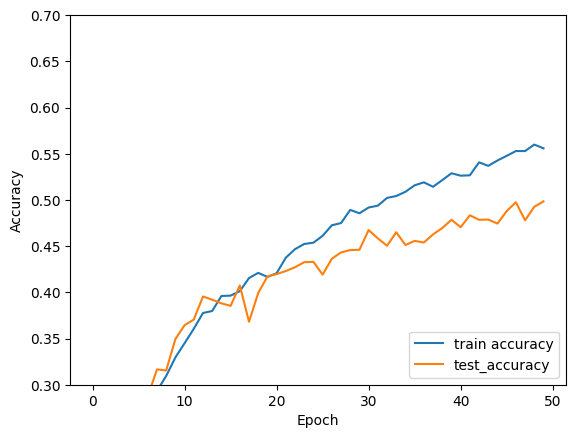

In [27]:
plt.plot(hist_tr_acc, label='train accuracy')
plt.plot(hist_te_acc, label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 0.7])
plt.legend(loc='lower right')

acc = eval(model, loader_test)
print('Test accuracy:', acc)

Now lets display a bunch of predictions of the model

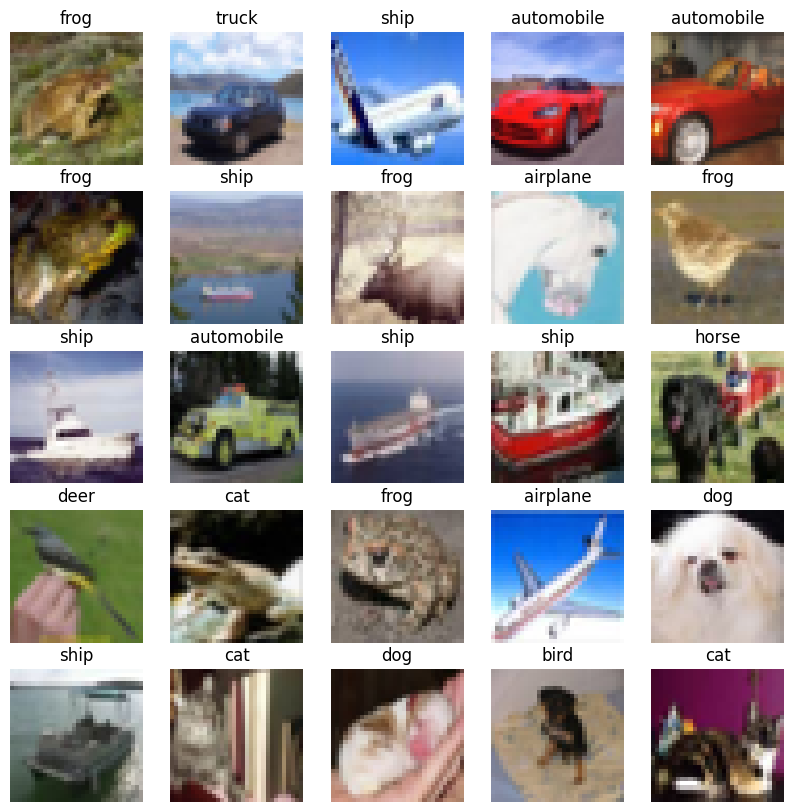

In [28]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    img, lbl = db_train[i]
    with torch.no_grad():
        pred = model(img[None])[0]
        pred = pred.argmax()
    plt.subplot(5,5,i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_names[pred])
    plt.axis(False)
plt.show()

Now lets see what the model learned at the first layer. Do you recognize any of these filters?

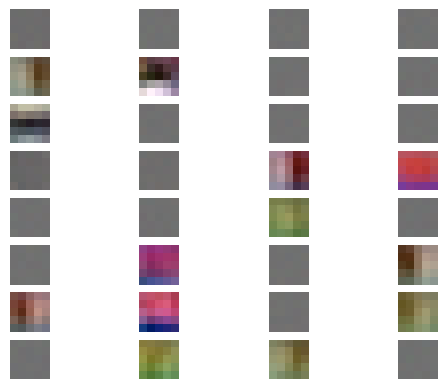

In [29]:
W = (model[0].weight - model[0].weight.min()) / (model[0].weight.max() - model[0].weight.min())
for i in range(32):
    plt.subplot(8, 4, i+1)
    plt.imshow(W[i].permute(1, 2, 0).detach())
    plt.axis(False)

In [4]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


transform = transforms.Compose([
    transforms.ToTensor(),
])
db_train = datasets.CIFAR10(root='./', train=True, transform=transform, download=True)
db_test = datasets.CIFAR10(root='./', train=False, transform=transform, download=True)
def subsample(db, n):
    idx = np.random.permutation(len(db))[:n]
    db.data = db.data[idx]
    db.targets = np.array(db.targets)[idx]
    return db

db_train = subsample(db_train, 5000)
db_test = subsample(db_test, 1000)

img, y = db_train[0]
print(img.shape, img.min(), img.max(), y)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32]) tensor(0.0078) tensor(1.) 0


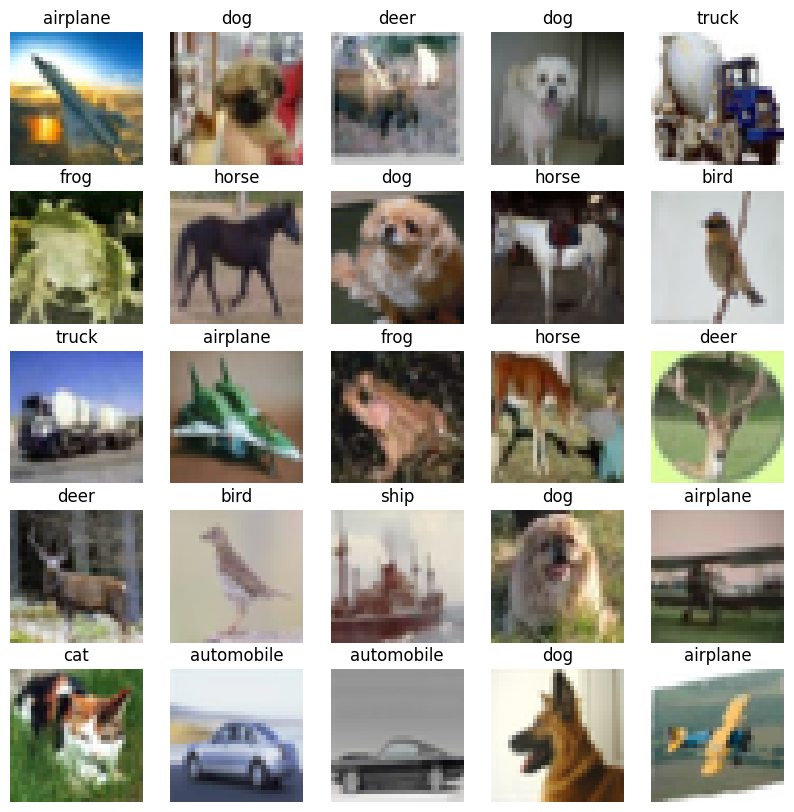

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    img, lbl = db_train[i]
    plt.subplot(5,5,i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_names[lbl])
    plt.axis(False)
plt.show()

In [19]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=(5, 5)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Conv2d(32, 64, kernel_size=(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Conv2d(64, 64, kernel_size=(3, 3)),
    nn.ReLU(),
)
dummy_img = torch.randn(1, 3, 32, 32)
print(model(dummy_img).shape)

torch.Size([1, 64, 4, 4])


In [8]:
from torch.utils.data import DataLoader
import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.normal_(m.weight, mean=0, std=0.005)

def accuracy(pred, labels):
    return (pred.argmax(-1) == labels).float().mean()


@torch.no_grad()
def eval(model, loader):
    accuracies = []
    for images, labels in tqdm.tqdm(loader):
        # Prepare data
        images = images.to(device)
        labels = labels.to(device)

        # Compute predictions, loss and accuracy
        pred = model(images)
        acc = accuracy(pred, labels)
        accuracies.append(acc.detach().item())
    return np.mean(accuracies)

def fit_one_epoch(model, opt, loader):
    losses, accuracies = [], []
    for images, labels in tqdm.tqdm(loader):
        # Prepare data
        images = images.to(device)
        labels = labels.to(device)

        # Compute predictions, loss and accuracy
        pred = model(images)
        l = loss(pred, labels)
        acc = accuracy(pred, labels)

        # Compute gradients and update the model
        opt.zero_grad()
        l.backward()
        opt.step()

        losses.append(l.detach().item())
        accuracies.append(acc.detach().item())
    return np.mean(losses), np.mean(accuracies)


def fit(model, loader_train, loader_test, epochs=10):
    opt = torch.optim.Adam(model.parameters(), lr=0.0005)
    hist_tr_loss, hist_tr_acc, hist_te_acc = [], [], []
    for epoch in range(epochs):
        tr_l, tr_acc = fit_one_epoch(model, opt, loader_train)
        te_acc = eval(model, loader_test)

        print(f"Finished epoch {epoch} of {epochs}: Train Loss = {tr_l:.3f}   Train Acc = {tr_acc:.3f}   Test Acc = {te_acc:.3f}", flush=True)
        hist_tr_loss.append(tr_l)
        hist_tr_acc.append(tr_acc)
        hist_te_acc.append(te_acc)
    return hist_tr_loss, hist_tr_acc, hist_te_acc

loader_train = DataLoader(db_train, batch_size=64, shuffle=True, drop_last=True)
loader_test = DataLoader(db_test, batch_size=64, shuffle=False)
loss = nn.CrossEntropyLoss()
model = model.to(device)
init_weights(model)
hist_tr_loss, hist_tr_acc, hist_te_acc = fit(model, loader_train, loader_test, epochs=30)

100%|██████████| 16/16 [00:00<00:00, 66.58it/s]

Finished epoch 0 of 30: Train Loss = 2.276   Train Acc = 0.122   Test Acc = 0.194



100%|██████████| 16/16 [00:00<00:00, 67.87it/s]

Finished epoch 1 of 30: Train Loss = 2.106   Train Acc = 0.207   Test Acc = 0.259



100%|██████████| 16/16 [00:00<00:00, 68.71it/s]

Finished epoch 2 of 30: Train Loss = 2.040   Train Acc = 0.242   Test Acc = 0.271



100%|██████████| 16/16 [00:00<00:00, 65.47it/s]

Finished epoch 3 of 30: Train Loss = 2.017   Train Acc = 0.252   Test Acc = 0.250



100%|██████████| 16/16 [00:00<00:00, 67.15it/s]

Finished epoch 4 of 30: Train Loss = 1.998   Train Acc = 0.258   Test Acc = 0.288



100%|██████████| 16/16 [00:00<00:00, 67.55it/s]

Finished epoch 5 of 30: Train Loss = 1.964   Train Acc = 0.267   Test Acc = 0.273



100%|██████████| 16/16 [00:00<00:00, 63.48it/s]

Finished epoch 6 of 30: Train Loss = 1.921   Train Acc = 0.289   Test Acc = 0.291



100%|██████████| 16/16 [00:00<00:00, 66.49it/s]

Finished epoch 7 of 30: Train Loss = 1.871   Train Acc = 0.310   Test Acc = 0.321



100%|██████████| 16/16 [00:00<00:00, 66.55it/s]

Finished epoch 8 of 30: Train Loss = 1.830   Train Acc = 0.332   Test Acc = 0.334



100%|██████████| 16/16 [00:00<00:00, 66.28it/s]

Finished epoch 9 of 30: Train Loss = 1.779   Train Acc = 0.350   Test Acc = 0.352



100%|██████████| 16/16 [00:00<00:00, 66.51it/s]

Finished epoch 10 of 30: Train Loss = 1.736   Train Acc = 0.363   Test Acc = 0.346



100%|██████████| 16/16 [00:00<00:00, 62.23it/s]

Finished epoch 11 of 30: Train Loss = 1.711   Train Acc = 0.374   Test Acc = 0.370



100%|██████████| 16/16 [00:00<00:00, 65.97it/s]

Finished epoch 12 of 30: Train Loss = 1.679   Train Acc = 0.385   Test Acc = 0.392



100%|██████████| 16/16 [00:00<00:00, 66.01it/s]

Finished epoch 13 of 30: Train Loss = 1.675   Train Acc = 0.393   Test Acc = 0.383



100%|██████████| 16/16 [00:00<00:00, 66.68it/s]

Finished epoch 14 of 30: Train Loss = 1.661   Train Acc = 0.402   Test Acc = 0.370



100%|██████████| 16/16 [00:00<00:00, 64.11it/s]

Finished epoch 15 of 30: Train Loss = 1.629   Train Acc = 0.413   Test Acc = 0.393



100%|██████████| 16/16 [00:00<00:00, 66.26it/s]

Finished epoch 16 of 30: Train Loss = 1.611   Train Acc = 0.420   Test Acc = 0.396



100%|██████████| 16/16 [00:00<00:00, 67.87it/s]

Finished epoch 17 of 30: Train Loss = 1.588   Train Acc = 0.422   Test Acc = 0.413



100%|██████████| 16/16 [00:00<00:00, 64.85it/s]

Finished epoch 18 of 30: Train Loss = 1.562   Train Acc = 0.437   Test Acc = 0.411



100%|██████████| 16/16 [00:00<00:00, 67.17it/s]

Finished epoch 19 of 30: Train Loss = 1.551   Train Acc = 0.438   Test Acc = 0.413



100%|██████████| 16/16 [00:00<00:00, 57.36it/s]

Finished epoch 20 of 30: Train Loss = 1.552   Train Acc = 0.446   Test Acc = 0.402



100%|██████████| 16/16 [00:00<00:00, 65.66it/s]

Finished epoch 21 of 30: Train Loss = 1.512   Train Acc = 0.453   Test Acc = 0.431



100%|██████████| 16/16 [00:00<00:00, 67.08it/s]

Finished epoch 22 of 30: Train Loss = 1.509   Train Acc = 0.455   Test Acc = 0.428



100%|██████████| 16/16 [00:00<00:00, 66.63it/s]

Finished epoch 23 of 30: Train Loss = 1.485   Train Acc = 0.461   Test Acc = 0.431



100%|██████████| 16/16 [00:00<00:00, 58.76it/s]

Finished epoch 24 of 30: Train Loss = 1.484   Train Acc = 0.468   Test Acc = 0.423



100%|██████████| 16/16 [00:00<00:00, 65.11it/s]

Finished epoch 25 of 30: Train Loss = 1.468   Train Acc = 0.468   Test Acc = 0.440



100%|██████████| 16/16 [00:00<00:00, 64.42it/s]

Finished epoch 26 of 30: Train Loss = 1.462   Train Acc = 0.472   Test Acc = 0.430



100%|██████████| 16/16 [00:00<00:00, 64.70it/s]

Finished epoch 27 of 30: Train Loss = 1.429   Train Acc = 0.486   Test Acc = 0.436



100%|██████████| 16/16 [00:00<00:00, 60.38it/s]

Finished epoch 28 of 30: Train Loss = 1.409   Train Acc = 0.493   Test Acc = 0.434



100%|██████████| 16/16 [00:00<00:00, 56.90it/s]

Finished epoch 29 of 30: Train Loss = 1.413   Train Acc = 0.493   Test Acc = 0.453


100%|██████████| 16/16 [00:00<00:00, 54.15it/s]


Test accuracy: 45.29%


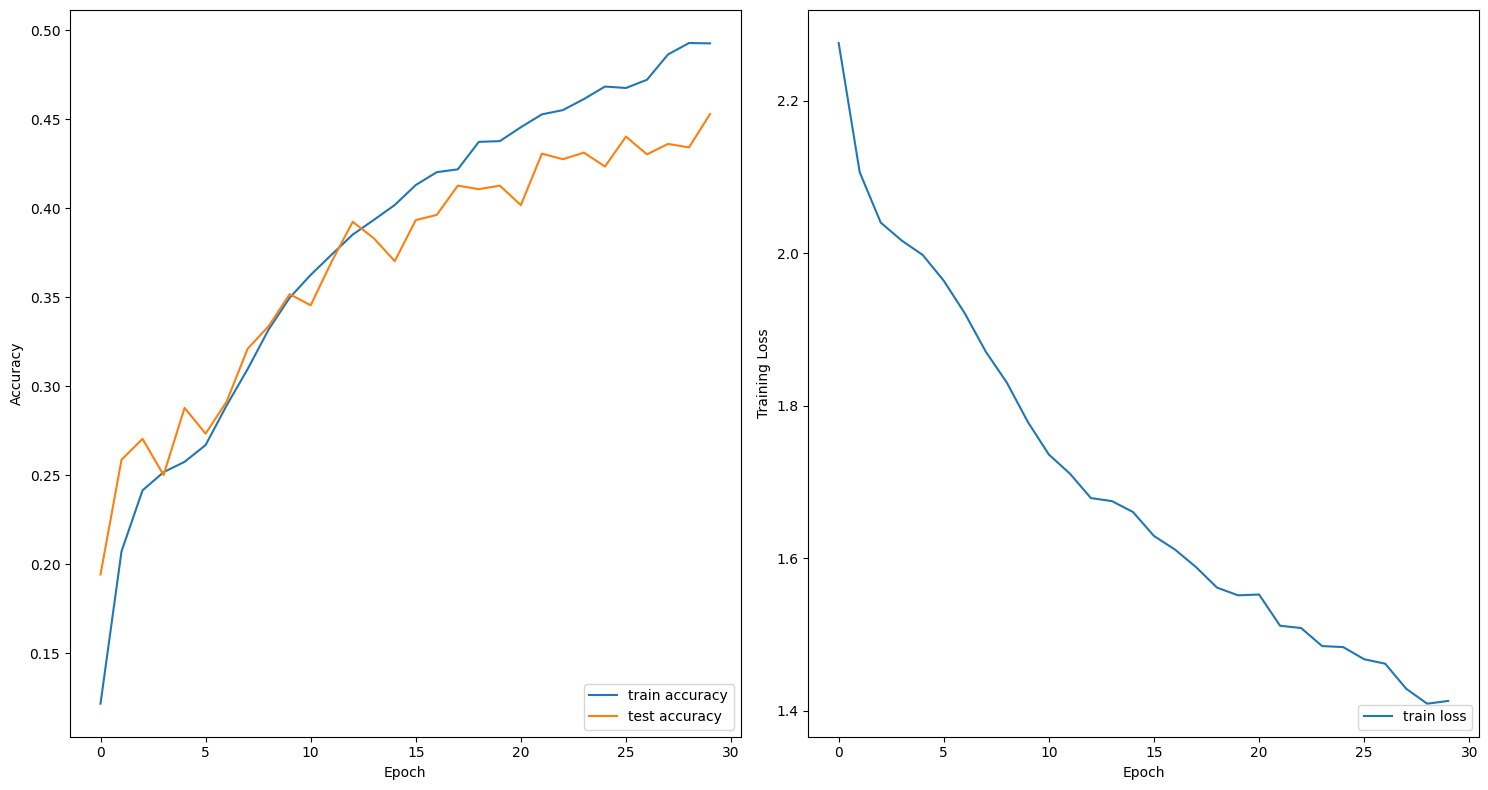

In [9]:
plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.plot(hist_tr_acc, label='train accuracy')
plt.plot(hist_te_acc, label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(hist_tr_loss, label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(loc='lower right')
plt.tight_layout()

acc = eval(model, loader_test)
print(f'Test accuracy: {acc*100:.2f}%')

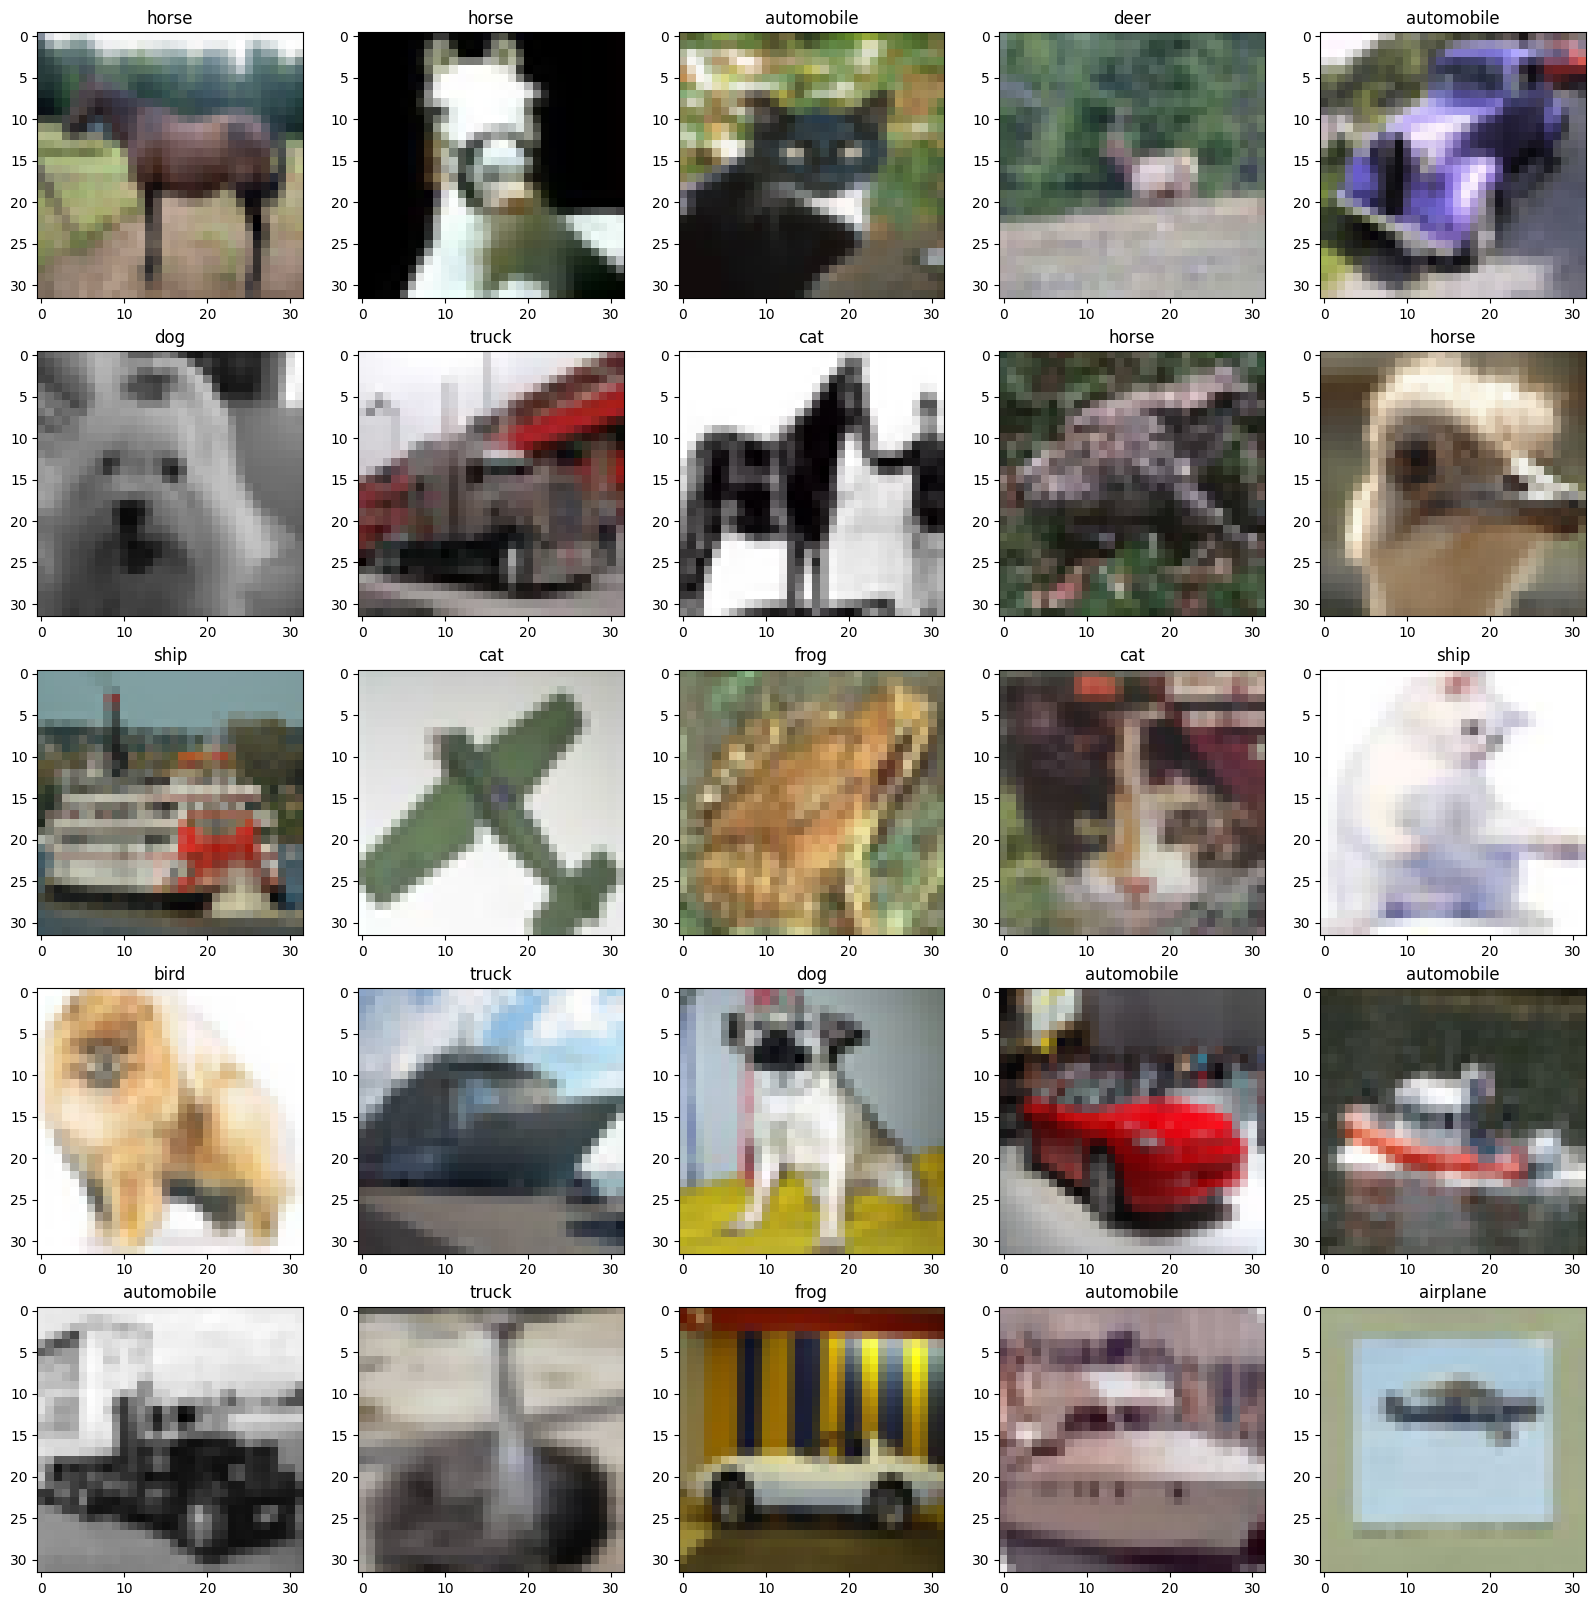

In [10]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
model = model.to(device)

plt.figure(figsize=(20,20))
for imgs, lbl in loader_test:
    with torch.no_grad():
        imgs = imgs.to(device)
        preds = model(imgs)
        preds = preds.argmax(1)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(imgs[i].cpu().permute(1, 2, 0))
        plt.title(class_names[preds[i]])
        # plt.axis(False)
plt.show()

In [15]:
class MyBatchNorm(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(1, dims, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, dims, 1, 1))

    def forward(self, x):
        # Compute mean and standard deviation across batch, height, and width
        mean = x.mean(dim=(0, 2, 3), keepdim=True)
        std = x.std(dim=(0, 2, 3), keepdim=True, unbiased=False)  # Unbiased=False for consistency with PyTorch's BatchNorm
        
        # Normalize input
        x_norm = (x - mean) / (std )
        
        # Scale and shift
        x_out = self.alpha * x_norm + self.beta
        
        return x_out


model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=(5, 5)),
    MyBatchNorm(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Conv2d(32, 64, kernel_size=(3, 3)),
    MyBatchNorm(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Conv2d(64, 64, kernel_size=(3, 3)),
    MyBatchNorm(64),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(1024, 10)
)

# Check the model
dummy_image = torch.randn(1, 3, 32, 32)
dummy_output = model(dummy_image)
print(f"{str(dummy_image.shape)} -> {str(dummy_output.shape)}")

torch.Size([1, 3, 32, 32]) -> torch.Size([1, 10])


In [ ]:
# Train the model
init_weights(model)
model = model.to(device)
hist_tr_loss, hist_tr_acc, hist_te_acc = fit(model, loader_train, loader_test, epochs=30)

# Plot training history
plt.subplot(1, 2, 1)
plt.plot(hist_tr_acc, label='train accuracy')
plt.plot(hist_te_acc, label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.3, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(hist_tr_loss, label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(loc='lower right')
plt.tight_layout()

# Evaluate
acc = eval(model, loader_test)
print(f'Test accuracy: {acc*100:.2f}%')

Transform 1


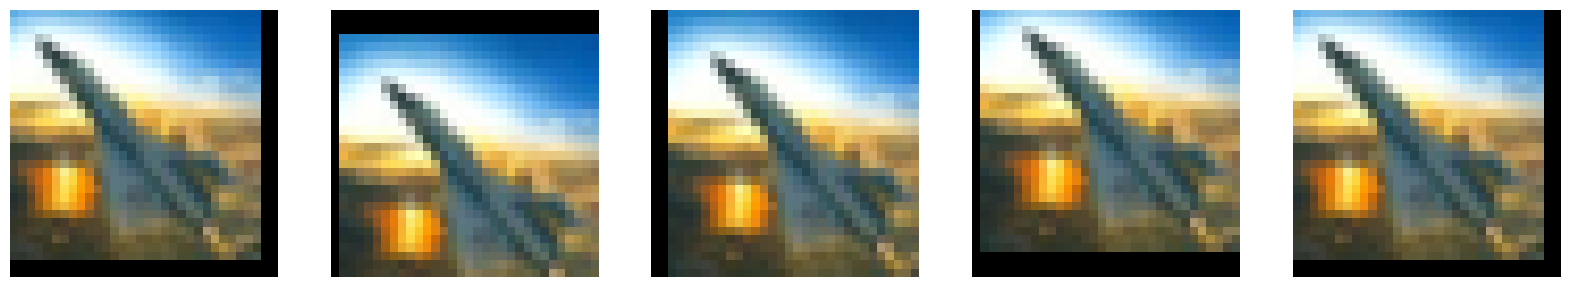

Transform 2


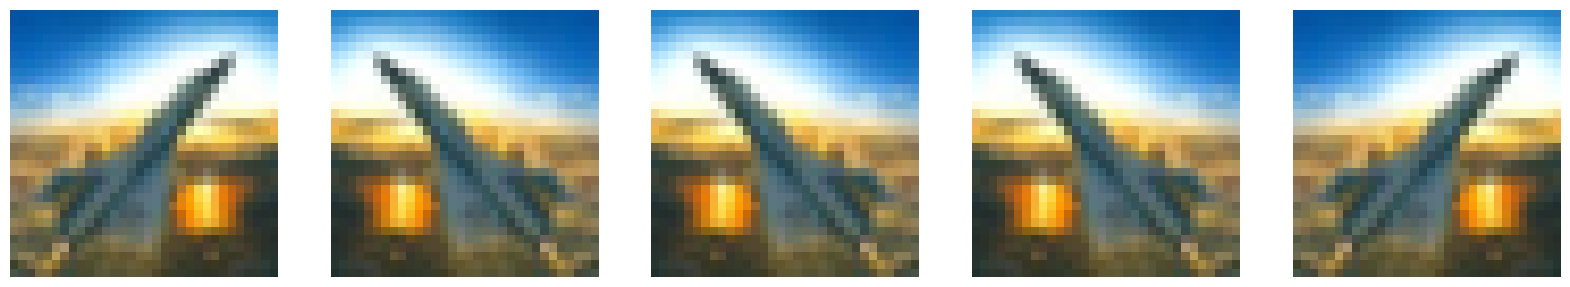

Transform 3


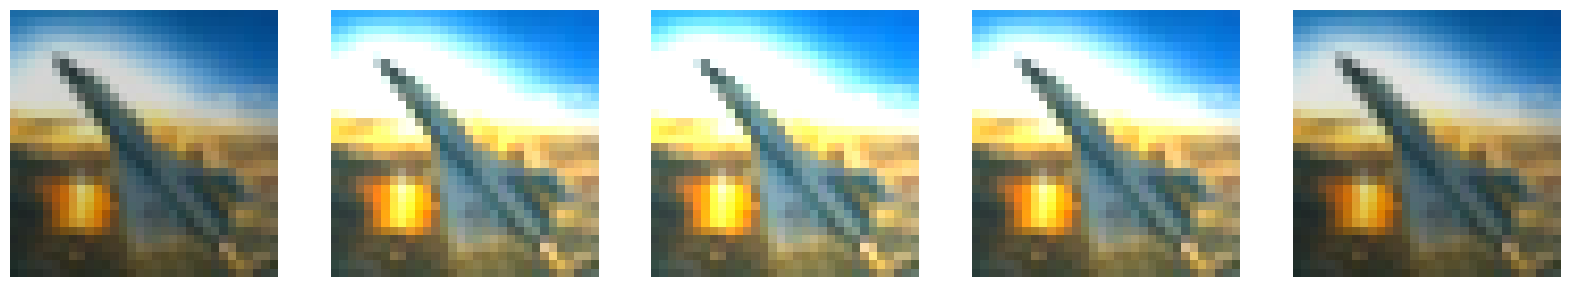

Transform 4


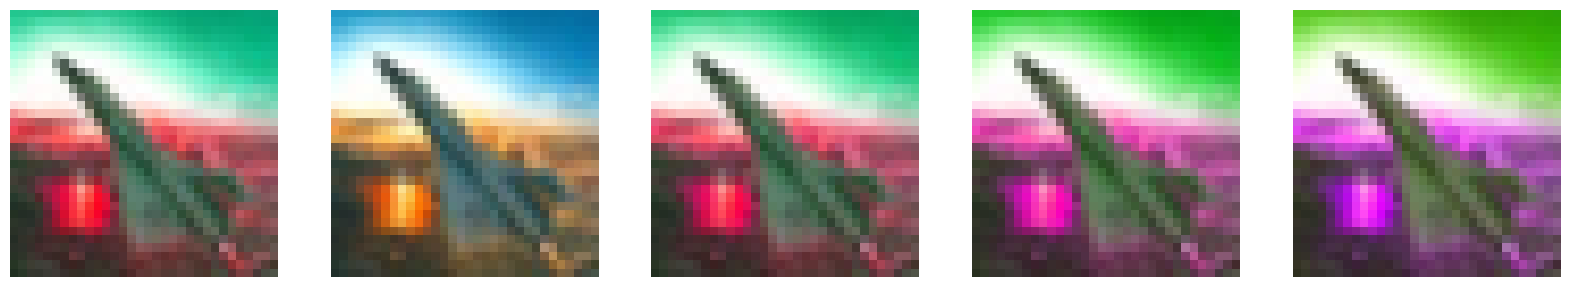

In [16]:
def display_transform(transform, image_idx=10):
    # The CIFAR dataset uses db.transform to transform each image.
    # We can change the data augmentation by assigning our new transformation to this variable.
    # See __getitem__ in https://pytorch.org/vision/stable/_modules/torchvision/datasets/cifar.html#CIFAR10 for how db.transform is used.
    db_train.transform = transform
    plt.figure(figsize=(20,6))
    for i in range(5):
        img, lbl = db_train[image_idx]
        plt.subplot(1,5,1+i)
        plt.imshow(img.permute(1, 2, 0))
        plt.axis(False)
    plt.show()

print("Transform 1")
transform1 = transforms.Compose([
    transforms.RandomCrop(size=[32,32], padding=3),
    transforms.ToTensor()
])
display_transform(transform1, image_idx=0)

print("Transform 2")
transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
])
display_transform(transform2, image_idx=0)

print("Transform 3")
transform3 = transforms.Compose([
    transforms.ColorJitter(brightness=0.5),
    transforms.ToTensor()
])
display_transform(transform3, image_idx=0)

print("Transform 4")
transform4 = transforms.Compose([
    transforms.ColorJitter(hue=0.5),
    transforms.ToTensor()
])
display_transform(transform4, image_idx=0)

100%|██████████| 16/16 [00:00<00:00, 33.28it/s]

Finished epoch 0 of 30: Train Loss = 1.839   Train Acc = 0.324   Test Acc = 0.373



100%|██████████| 16/16 [00:00<00:00, 35.98it/s]

Finished epoch 1 of 30: Train Loss = 1.596   Train Acc = 0.413   Test Acc = 0.443



100%|██████████| 16/16 [00:00<00:00, 38.02it/s]

Finished epoch 2 of 30: Train Loss = 1.482   Train Acc = 0.463   Test Acc = 0.466



100%|██████████| 16/16 [00:00<00:00, 33.79it/s]

Finished epoch 3 of 30: Train Loss = 1.416   Train Acc = 0.488   Test Acc = 0.529



100%|██████████| 16/16 [00:00<00:00, 36.33it/s]

Finished epoch 4 of 30: Train Loss = 1.333   Train Acc = 0.517   Test Acc = 0.496



100%|██████████| 16/16 [00:00<00:00, 36.04it/s]

Finished epoch 5 of 30: Train Loss = 1.297   Train Acc = 0.529   Test Acc = 0.516



100%|██████████| 16/16 [00:00<00:00, 35.64it/s]

Finished epoch 6 of 30: Train Loss = 1.237   Train Acc = 0.557   Test Acc = 0.580



100%|██████████| 16/16 [00:00<00:00, 36.86it/s]

Finished epoch 7 of 30: Train Loss = 1.206   Train Acc = 0.578   Test Acc = 0.557



100%|██████████| 16/16 [00:00<00:00, 36.19it/s]

Finished epoch 8 of 30: Train Loss = 1.162   Train Acc = 0.588   Test Acc = 0.546



100%|██████████| 16/16 [00:00<00:00, 36.92it/s]

Finished epoch 9 of 30: Train Loss = 1.129   Train Acc = 0.606   Test Acc = 0.572



100%|██████████| 16/16 [00:00<00:00, 36.49it/s]

Finished epoch 10 of 30: Train Loss = 1.116   Train Acc = 0.600   Test Acc = 0.587



100%|██████████| 16/16 [00:00<00:00, 31.67it/s]

Finished epoch 11 of 30: Train Loss = 1.073   Train Acc = 0.624   Test Acc = 0.570



100%|██████████| 16/16 [00:00<00:00, 36.19it/s]

Finished epoch 12 of 30: Train Loss = 1.027   Train Acc = 0.642   Test Acc = 0.593



100%|██████████| 16/16 [00:00<00:00, 37.50it/s]

Finished epoch 13 of 30: Train Loss = 0.998   Train Acc = 0.647   Test Acc = 0.599



100%|██████████| 16/16 [00:00<00:00, 35.51it/s]

Finished epoch 14 of 30: Train Loss = 0.986   Train Acc = 0.655   Test Acc = 0.581



100%|██████████| 16/16 [00:00<00:00, 35.17it/s]

Finished epoch 15 of 30: Train Loss = 0.961   Train Acc = 0.668   Test Acc = 0.602



100%|██████████| 16/16 [00:00<00:00, 35.83it/s]

Finished epoch 16 of 30: Train Loss = 0.919   Train Acc = 0.678   Test Acc = 0.579



100%|██████████| 16/16 [00:00<00:00, 34.45it/s]

Finished epoch 17 of 30: Train Loss = 0.917   Train Acc = 0.687   Test Acc = 0.586



100%|██████████| 16/16 [00:00<00:00, 26.23it/s]

Finished epoch 18 of 30: Train Loss = 0.891   Train Acc = 0.690   Test Acc = 0.607



100%|██████████| 16/16 [00:00<00:00, 35.51it/s]

Finished epoch 19 of 30: Train Loss = 0.885   Train Acc = 0.693   Test Acc = 0.615



100%|██████████| 16/16 [00:00<00:00, 36.41it/s]

Finished epoch 20 of 30: Train Loss = 0.834   Train Acc = 0.716   Test Acc = 0.610



100%|██████████| 16/16 [00:00<00:00, 35.90it/s]

Finished epoch 21 of 30: Train Loss = 0.829   Train Acc = 0.711   Test Acc = 0.576



100%|██████████| 16/16 [00:00<00:00, 36.07it/s]

Finished epoch 22 of 30: Train Loss = 0.821   Train Acc = 0.714   Test Acc = 0.603



100%|██████████| 16/16 [00:00<00:00, 35.38it/s]

Finished epoch 23 of 30: Train Loss = 0.783   Train Acc = 0.733   Test Acc = 0.603



100%|██████████| 16/16 [00:00<00:00, 36.39it/s]

Finished epoch 24 of 30: Train Loss = 0.782   Train Acc = 0.734   Test Acc = 0.611



100%|██████████| 16/16 [00:00<00:00, 35.63it/s]

Finished epoch 25 of 30: Train Loss = 0.758   Train Acc = 0.738   Test Acc = 0.602



100%|██████████| 16/16 [00:00<00:00, 33.87it/s]

Finished epoch 26 of 30: Train Loss = 0.749   Train Acc = 0.749   Test Acc = 0.620



100%|██████████| 16/16 [00:00<00:00, 37.77it/s]

Finished epoch 27 of 30: Train Loss = 0.714   Train Acc = 0.759   Test Acc = 0.622



100%|██████████| 16/16 [00:00<00:00, 36.32it/s]

Finished epoch 28 of 30: Train Loss = 0.696   Train Acc = 0.765   Test Acc = 0.610



100%|██████████| 16/16 [00:00<00:00, 36.12it/s]

Finished epoch 29 of 30: Train Loss = 0.703   Train Acc = 0.760   Test Acc = 0.616



100%|██████████| 16/16 [00:00<00:00, 33.27it/s]

Test accuracy: 61.64%


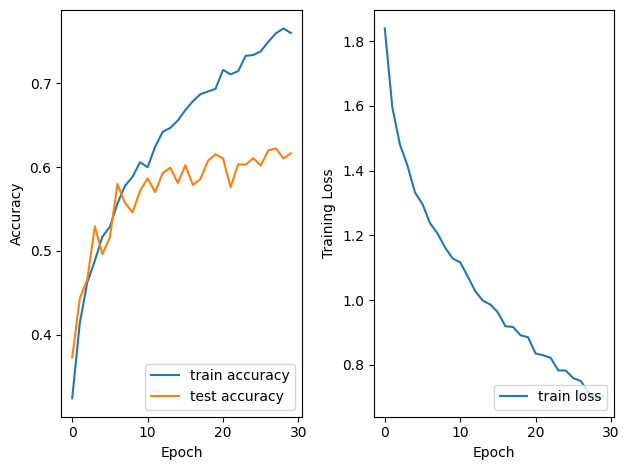

In [18]:
# Define new transform
db_train.transform = transforms.Compose([
    transforms.RandomRotation(40),
    transforms.ToTensor()
])

loader_train = DataLoader(db_train, batch_size=64, shuffle=True, drop_last=True)
loader_test = DataLoader(db_test, batch_size=64, shuffle=False)
loss = nn.CrossEntropyLoss()
init_weights(model)
hist_tr_loss, hist_tr_acc, hist_te_acc = fit(model, loader_train, loader_test, epochs=30)

# Plot training history
plt.subplot(1, 2, 1)
plt.plot(hist_tr_acc, label='train accuracy')
plt.plot(hist_te_acc, label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.3, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(hist_tr_loss, label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(loc='lower right')
plt.tight_layout()

# Evaluate
acc = eval(model, loader_test)
print(f'Test accuracy: {acc*100:.2f}%')